<p style="font-size:30px;font-weight:bold;text-align:center;color:black;">Recommender Systems</p>

<p style="font-size:20px;text-align:center;color:blue;">Master of foundation of Data Science</p>


<br>
<p style="font-size:20px;font-weight:bold;text-align:center;color:black;">Content Based Recommenders</p>



# Introduction

[Jester](http://eigentaste.berkeley.edu/about.html) is a joke recommender system developed at UC Berkeley to study social information filtering. Their [dataset](http://eigentaste.berkeley.edu/dataset/) contains over 5 million anonymous joke ratings from 150k users. In this case, we will use the **Dataset 1** which contains over 4.1 million 
continuous ratings (-10.00 to +10.00) of 100 jokes from 73,421 users, collected between April 1999 - May 2003.

<img src="1.png",width=600,height=600,href="http://eigentaste.berkeley.edu/about.html">

An example of a joke in this dataset could be the next one (These jokes have been screened but if you are sensitive or under 18, please don't enter.): 

<img src="2.png",width=650,height=650>

## Goal

The aim of this project is to learn how to apply different techniques in Recommender Systems. In particular, we will use:
<ul>
  <li>Content based</li>
</ul>

We evaluate all this methods using the Normalized Absolut Error (NMAE) on both training and test split.

# Get the data  


In [2]:
import numpy as np
import pandas as pd
import random

In [3]:
df1 = pd.read_excel('data/jester-data-1.xls',header=None)
df2 = pd.read_excel('data/jester-data-2.xls',header=None)
df3 = pd.read_excel('data/jester-data-3.xls',header=None)

df_original = pd.concat([df1,df2,df3])
# create an Id for each user
df_original.index = range(len(df_original))

In [4]:
# delete the first row, which only contained the number og items rated by user
df_original.drop(df_original.columns[[0]], axis=1, inplace=True)

#now df contains the ratings of each user to all movies (99 means not seen)
df_original.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


## Test and Training split

In [5]:
MISSING_RATING = 99
NUM_SAMPLES = 500
random.seed(1)

# Get a subsample datset of NUM_SAMPLES samples
df = df_original.sample(NUM_SAMPLES)

# Divide the data into training and test set
train_df = pd.DataFrame(columns=df_original.columns.tolist())

# df.index are the NUM_SAMPLES id's of the users
training = pd.DataFrame(index=df.index,columns=['items','#items'])
test = pd.DataFrame(index=df.index,columns=['items','#items'])

# equivalence from users index (in dataframe) to positions (in matrix)
d = {}

i = 1 
for index,row in df.iterrows():
    # equivalence
    d[index] = i
    i += 1
    
    # delete items that where not rated by the user
    l = row[row!=99]   
    
    # get 75% of the index for training and 25% for testing
    training_indexes = random.sample(list(l.index), int(0.75*(len(l))) )
    test_indexes = list(set(l.index) - set(training_indexes))
    
    # change the test indexes to unknown and append to the training df
    row[test_indexes] = MISSING_RATING
    train_df = train_df.append(row)
    
    # Assign the items to the datasets
    test['items'].loc[index] = test_indexes
    test['#items'].loc[index] = len(test_indexes)
    training['items'].loc[index] = training_indexes
    training['#items'].loc[index] = len(training_indexes)
   

## Content Based Model

This model is based on item-item similarity. First, we read the text for each joke. Second, we 'clean' this text, and third, we describe each joke in a space of frequency of words in a BoW, representing each joke with a vector. Finally, we compute the similarity of the jokes in this space with again the cosinus distance, in order to have a new content-based similarity matrix. After that, we apply the prediction functions used above and we discuss the results.

## Get the jokes content
Read the data from html to dataframe preserving the same index for each joke than in previous experiments:

In [6]:
!pip install html2text

You are using pip version 9.0.1, however version 9.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
# from:
# http://blog.untrod.com/2016/06/simple-similar-products-recommendation-engine-in-python.html

import html2text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

def get_jokes_test():
    jokes = pd.DataFrame({'joke' : [],'id' : []})

    jokes = jokes.append({'joke' : '', 'id': 0}, ignore_index=True)
    for i in range(1, 101):
        with open("data/jokes/init"+str(i)+".html") as f:
            jokes = jokes.append({'joke' : html2text.html2text(f.read()), 'id': i},
                                 ignore_index=True)
    jokes.drop(0, axis=0, inplace=True)
    return jokes

jokes = get_jokes_test()

An overview and a specific example:

In [8]:
# overview
jokes.head()

,id,joke
1,1.0,"\nA man visits the doctor. The doctor says ""..."
2,2.0,| \n\n \nThis couple had an excellent relati...
3,3.0,| \n\n \nQ. What's 200 feet long and has 4 t...
4,4.0,| \n\n \nQ. What's the difference between a ...
5,5.0,| \n\n \nQ. What's O. J. Simpson's Internet ...


In [9]:
# Specific example
print(jokes.loc[1]['joke'])

  
A man visits the doctor. The doctor says "I have bad news for you.You have
cancer and Alzheimer's disease".

The man replies "Well,thank God I don't have cancer!"




## Features extraction, engineering, and similarity matrix

In [10]:
def similarity_matrix_content_base(jokes_df, min_df = 0.05, ngram_range=(1, 3)):
    """ This function takes a set of sentence and computes the similarity between them """
    tf = TfidfVectorizer(analyzer='word', ngram_range = ngram_range, min_df = min_df, stop_words='english')
    
    # get the representation of our data in the new space from raw text
    tfidf_matrix = tf.fit_transform(jokes_df['joke'])
    
    # compute the similaities between the senteces
    sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    return sim

#compute simiarlity between jokes
S_CB = similarity_matrix_content_base(jokes)

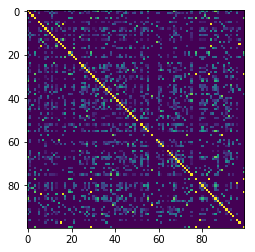

In [11]:
import matplotlib.pylab as plt
plt.imshow(S_CB)
plt.show()

In [12]:
#most similar joke to target_joke
target_joke = 1
print('******************    TARGET JOKE     *******************')
print(jokes.iloc[target_joke]['joke'])
print('****************** MOST SIMILAR JOKE  *******************')
print(jokes.iloc[np.argsort(-S_CB[target_joke,:])[1]]['joke'])

******************    TARGET JOKE     *******************
|  

  
This couple had an excellent relationship going until one day he came home
from work to find his girlfriend packing. He asked her why she was leaving him
and she told him that she had heard awful things about him.

"What could they possibly have said to make you move out?"

"They told me that you were a pedophile."

He replied, "That's an awfully big word for a ten year old."  
---|---


****************** MOST SIMILAR JOKE  *******************
  
|

  
Two kindergarten girls were talking outside: one said, "You won't believe what
I saw on the patio yesterday--a condom!"

The second girl asked, "What's a patio?"  
---|---




## Content-Based Model

In [13]:
from sklearn.metrics import mean_absolute_error
MAX_RATING = 10.
MIN_RATING = -10.
class CB():
    def __init__(self, X , sim_function):
        self.Xtrain = X
        self.sim_item2item = [] # Similarity Matrix between items
        self.sim_function = sim_function # Function to compute item similarities
        
        
    def fit(self,items):
        '''Learn Similarities between items'''
        return 0
        
    def predict(self, user_id, item_id):
        '''Given a user_id and item_id predict it score'''
        return 0
    
    def evaluate(self, XTest, df_full):
        '''Evaluate System using training set'''
        y_true = []
        y_pred = []
        for user_id,_ in test.iterrows():
            y_true.append(list(df_original.loc[user_id][test.loc[user_id]['items']].values))
            y_pred.append([cb_recsys.predict(user_id,item_id) for item_id in test.loc[user_id]['items']])
            
        y_pred = np.array(sum(y_pred, []))
        y_true = np.array(sum(y_true, []))
        MAE = np.mean(np.abs(y_true-y_pred))
        RMSE = np.sqrt(np.mean(np.abs(y_true-y_pred)))
        print('MAE = ',MAE)
        print('RMSE = ', RMSE)
        return MAE,y_true,y_pred
    
cb_recsys = CB(training, sim_function = similarity_matrix_content_base)
cb_recsys.fit(jokes)
res, y_true, y_pred =  cb_recsys.evaluate(test,df_original)


MAE =  4.00528098776
RMSE =  2.00131981147


### Exercice: Implment the methods  fit and predict from the class ContentBased recommender.